# GAN

In this section you are required to implement vanilla GAN. The general structure for GAN is given below. You can use it as a template.

Generative Adversarial Networks are used for learning distribution of data by playing a game between two networks which are generator and discriminator.

There are couple of studies you can examine before implementing the model.

Generative Adversarial Networks: https://arxiv.org/abs/1406.2661

Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks: https://arxiv.org/abs/1511.06434

# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



# I'm using local PC

In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Tue Dec 10 16:07:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P0    70W / 275W |    256MiB / 11175MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import cv2
%matplotlib inline

We are setting necessary parameters up first.

In [4]:
noise_dim = 100 # size of noise for generator

batch_size = 8 # for GAN training
epochs = 3 # for GAN training

disc_map_size = 64 # for discriminator network
gen_map_size = 64 # for generator network

lr = 0.0001 # for Adam
beta1 = 0.5 # for Adam

device = "cuda" # device selection for storing tensors

Since we are using "tanh" output in our generator, we must normalize our input images between -1 and 1 aswell. So, we will define a rescaler function to do this operation.

In [5]:
def rescale(element, min_before, max_before, min_after, max_after):
    rescaled = min_after + (element - min_before) * ((max_after - min_after) / (max_before - min_before))
    return rescaled

# Load the Logo data as instructed below
We used the rescaler function here to get normalized input data from the dataloader.

In [6]:
class logoLoader(Dataset):
    def __init__(self, path):
      d_array = []

      for i in range(5):
        root = os.path.join(path, 'LLD-icon_data_{}.pkl'.format(i))
        data = np.load(root, encoding='latin1',allow_pickle=True)
        d_array.append(data)
      
      self.data = np.concatenate((d_array[0],d_array[1],d_array[2],d_array[3],d_array[4]))
      print(self.data.shape)
    
    # This method should be overrided in order to access the inside of dataset, gets normalized input data    
    def __getitem__(self, ix):

      return rescale(self.data[ix], 0, 255, -1, 1)


    # Gets raw input data
    def __getitem_raw__(self, ix):

      return self.data[ix]

    # This method should be overrided in order to make it work along with DataLoader class
    def __len__(self):
        return len(self.data)

In [7]:
dataset = logoLoader(path='./DL_HW3_Data')
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=8, shuffle=True)

(486377, 32, 32, 3)


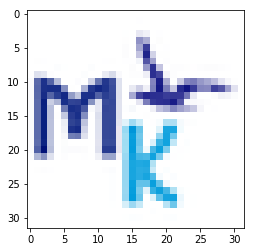

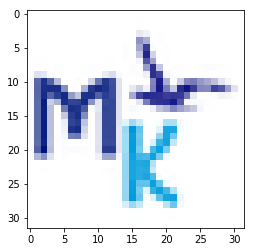

In [8]:
plt.imshow(rescale(dataset.__getitem__(350), -1, 1, 0, 255).astype(int)) ## to avoid matplotlib's float mode
plt.show()

plt.imshow(dataset.__getitem_raw__(350))
plt.show()

# Implement the Discriminator Architecture of your Design

Use Conv2d, Linear and Activation Layers to design a Discriminator

Please note: Pay attention to whether Sigmoid Unit at the last layer is added in the Architecture OR in the Loss function, because in implementations of some loss functions in Pytorch, sigmoid unit is included by default. In this notebook we use BCELoss (given default) so you should add sigmoid to last layer.

We simply create our weight initializator according to DCGAN paper.

In [9]:
def init_w(m):
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

We define our discriminator function for our GAN architecture.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, map_size):
        
        super(Discriminator, self).__init__()
        
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        self.conv1 = nn.Conv2d(3, map_size, 4, 2, 1, bias=False)
        
        self.conv2 = nn.Conv2d(map_size, map_size * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(map_size * 2)
        
        self.conv3 = nn.Conv2d(map_size * 2, map_size * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(map_size * 4)
        
        self.conv4 = nn.Conv2d(map_size * 4, map_size * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(map_size * 8)
        
        self.conv5 = nn.Conv2d(map_size * 8, 1, 2, 2, 0, bias=False)

    def forward(self, input):
        
        x = self.lrelu(self.conv1(input))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.lrelu(self.bn3(self.conv3(x)))
        x = self.lrelu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = self.sigmoid(x)
        
        return x

In [11]:
# Creating the generator and send it to the CUDA device
discriminator = Discriminator(disc_map_size).to(device)

# Initializing the weights for it
discriminator.apply(init_w)

Discriminator(
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
)

# Implement the Generator Architecture of your Design

You can use (Upsample, Conv2d) pair or ConvTranspose2d and Activation Layers to design a Generator. Add Tanh to last layer for better training.


In [12]:
class Generator(nn.Module):
    
    def __init__(self, map_size, noise_dim):
        
        super(Generator, self).__init__()
        
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()
        
        self.ct1 = nn.ConvTranspose2d(noise_dim, map_size * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(map_size * 8)
        
        self.ct2 = nn.ConvTranspose2d(map_size * 8, map_size * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(map_size * 4)
        
        self.ct3 = nn.ConvTranspose2d(map_size * 4, map_size * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(map_size * 2)
        
        self.ct4 = nn.ConvTranspose2d(map_size * 2, map_size, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(map_size)
        
        self.ct5 = nn.ConvTranspose2d(map_size, 3, 1, 1, 0, bias=False)

    def forward(self, input):
        
        x = self.lrelu(self.bn1(self.ct1(input))) # size 4x4
        x = self.lrelu(self.bn2(self.ct2(x))) # size 8x8
        x = self.lrelu(self.bn3(self.ct3(x))) # size 16x16
        x = self.lrelu(self.bn4(self.ct4(x))) # size 32x32
        x = self.ct5(x) # size 32x32
        x = self.tanh(x)
        
        return x

In [13]:
# Creating the generator and send it to the CUDA device
generator = Generator(gen_map_size, noise_dim).to(device)

# Initializing the weights for it
generator.apply(init_w)

Generator(
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (tanh): Tanh()
  (ct1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ct5): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [14]:
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr*4, betas=(beta1, 0.999))
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# VanillaGAN uses Binary Cross Entropy loss, instatiated below.

In [15]:
bce_loss = nn.BCELoss()

We create and implement our plotter function to see if our data is expected for us or not.

In [16]:
def show_images(images):
    
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn*3, sqrtn*3))
    gs = gridspec.GridSpec(sqrtn*2, sqrtn*2)
    gs.update(wspace=0.15, hspace=0.15)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        img = img.reshape([32, 32, 3])
        img = np.array(img, dtype='uint8')
        img = cv2.resize(img,None,fx=3,fy=3)
        plt.imshow(img)

We will define a noise function to be an input for our generator model. Also the noise must be rescaled in between -1 and 1.

In [17]:
def create_noise(batch_size, dim, device):

    noise = torch.rand((batch_size, noise_dim, 1, 1), device=device)*2-1
    
    return noise

We will create a function that generates labels with the size of batches for real inputs. But we used the "inverse label" and "smoothening labels" methods that proposed in earlier papers to get more robust results.

In [18]:
def get_real_label(batch_size, device):
    
    label = torch.rand((batch_size,), device=device) * 0.1
    
    return label

We will create a function that generates labels with the size of batches for fake inputs. But we used the "inverse label" and "smoothening labels" methods that proposed in earlier papers to get more robust results.

In [19]:
def get_fake_label(batch_size, device):
    
    label = 1 - torch.rand((batch_size,), device=device) * 0.1
    
    return label

We will create a function that inverses the normalization on the images to show them properly.

In [20]:
def showable_image(input):
    
    return rescale(input, -1, 1, 0, 255).astype(int)

# Implement training loop

In [21]:
def gan_train(dataloader, disc, gen, disc_optimizer, gen_optimizer, epochs, batch_size, noise_dim, stat_freq=250, sample_freq=1250, device="cuda"):
    
    # We create a fixed noise to see the improvement of our generator model on the same input
    fixed_noise = create_noise(batch_size, noise_dim, device)    
    
    losses_gen = []
    losses_disc = []
    
    for epoch in range(epochs):
        for n_batch, (real_batch) in enumerate(dataloader):

            # Checking if the batch size is appropriate
            if len(real_batch) != batch_size:
                continue

            ## Training of the Discriminator Model ##

            ## Real Data Part##

            # We will change the order of pixels and channels to get a proper input for our GAN and move it into our device
            real_batch = real_batch.reshape(batch_size,3,32,32).type(torch.cuda.FloatTensor)

            # Zeroing the discriminator's gradients
            disc.zero_grad()

            # Get the labels for real input       
            label = get_real_label(batch_size, device)

            # Forward pass the real input on our discriminator and flatten the output
            output = disc(real_batch).view(-1)

            # Calculate the BCE loss on our real-data batch
            real_error_disc = bce_loss(output, label)

            # Calculate the gradients of our discriminator
            real_error_disc.backward()

            ## Fake Data Part##

            # Create a noise for our generator network
            noise = create_noise(batch_size, noise_dim, device)

            # Generate a batch of fake images with our generator
            fake = gen(noise)

            # Get the labels for our generated fake input 
            label = get_fake_label(batch_size, device)

            # Forward pass the fake input on our discriminator and flatten the output
            output = disc(fake.detach()).view(-1)

            # Calculate the BCE loss on our fake-data batch
            fake_error_disc = bce_loss(output, label)

            # Calculate the gradients of our discriminator
            fake_error_disc.backward()

            # Calculate the total loss of our discriminator
            total_error_disc = real_error_disc + fake_error_disc

            # Run the optimization step for our discriminator
            disc_optimizer.step()


            ## Training of the Generator Model ##

            # Zeroing the generator's gradients
            gen.zero_grad()

            # Get the labels for real input  
            label = get_real_label(batch_size, device)

            # Forward pass the fake input on our "updated" discriminator and flatten the output
            output = disc(fake).view(-1)

            # Calculate the BCE loss of generator model on our fake-data batch
            error_gen = bce_loss(output, label)

            # Calculate the gradients of our generator
            error_gen.backward()

            # Run the optimization step for our generator
            gen_optimizer.step()

            # Showing loss statistics of the updated models
            if (n_batch + 1) % stat_freq == 0:
                print("epoch: %d, batch number: %d, disc_loss: %.4f, gen_loss: %.4f" % 
                      (epoch + 1, n_batch + 1, total_error_disc.item(), error_gen.item()))

            # Showing samples from the current generator model    
            if (n_batch + 1) % sample_freq == 0:
                with torch.no_grad():
                    imgs_numpy = gen(noise).detach().cpu().numpy()
                    imgs_numpy = showable_image(imgs_numpy)
                    show_images(imgs_numpy[0:6])
                    plt.show()
            
            # Save our loss results both for discriminator and generator
            losses_gen.append(error_gen.item())
            losses_disc.append(total_error_disc.item())

    return gen, losses_gen, losses_disc
    

We will call our GAN trainer function and get our final generator model, losses for generator and discriminator.

epoch: 1, batch number: 15000, disc_loss: 0.6475, gen_loss: 2.0753
epoch: 1, batch number: 30000, disc_loss: 0.3957, gen_loss: 3.4077


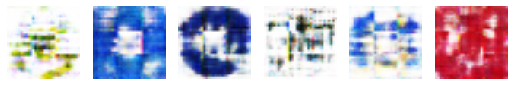

epoch: 1, batch number: 45000, disc_loss: 0.8398, gen_loss: 5.5514
epoch: 1, batch number: 60000, disc_loss: 0.4448, gen_loss: 2.8188


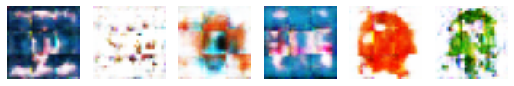

epoch: 2, batch number: 15000, disc_loss: 0.4271, gen_loss: 2.7891
epoch: 2, batch number: 30000, disc_loss: 0.4681, gen_loss: 3.2411


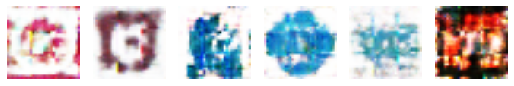

epoch: 2, batch number: 45000, disc_loss: 0.4632, gen_loss: 2.6943
epoch: 2, batch number: 60000, disc_loss: 0.6827, gen_loss: 2.8137


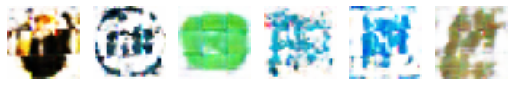

epoch: 3, batch number: 15000, disc_loss: 0.4317, gen_loss: 3.6309
epoch: 3, batch number: 30000, disc_loss: 0.4535, gen_loss: 2.5658


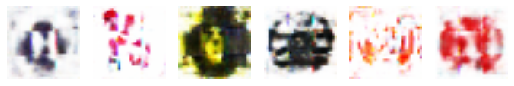

epoch: 3, batch number: 45000, disc_loss: 0.3606, gen_loss: 2.7286
epoch: 3, batch number: 60000, disc_loss: 0.4820, gen_loss: 2.8827


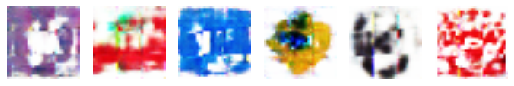

In [22]:
generator, l_gen, l_disc = gan_train(data_loader, discriminator, generator, disc_optimizer, gen_optimizer, epochs, batch_size, noise_dim, stat_freq=15000, sample_freq=30000, device="cuda")

## Report the training loss curves and test results (generated images) vanillaGAN. Also briefly discuss the results.

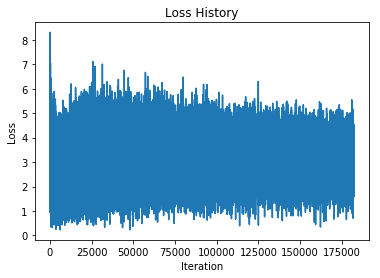

In [23]:
# Plot Generator Loss 

set_size = np.arange(len(l_gen))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(set_size, l_gen)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss History")
plt.show()

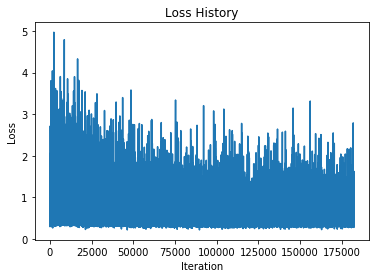

In [24]:
# Plot Discriminator Loss

set_size = np.arange(len(l_disc))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(set_size, l_disc)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss History")
plt.show()

Samples from the final generator model are as follows

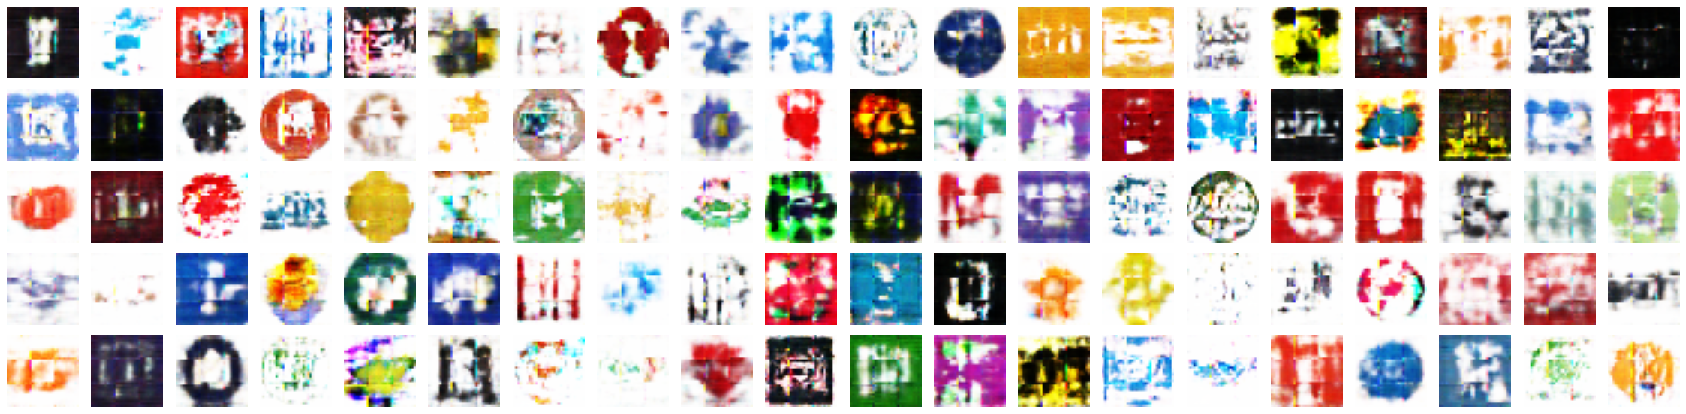

In [25]:
noise = create_noise(100, noise_dim, device)
samples = generator(noise).detach().cpu().numpy()
samples_img = showable_image(samples)
show_images(samples_img[0:100])
plt.show()

In [26]:
disc_avg_l = np.mean(l_disc[-1000:-1])
gen_avg_l = np.mean(l_gen[-1000:-1])

print("Average Discriminator Loss: " + str(disc_avg_l))
print("Average Generator Loss: " + str(gen_avg_l))

Average Discriminator Loss: 0.46945968070426386
Average Generator Loss: 3.0092158256708323


We actually want discriminator loss to converge on 0.5. Because it's the uncertainty state and the discriminator would not really know if the given image is real or fake. We calculated the mean of the latest discrimator loss as above, so our generator is good enough to fool our discriminator.

#### After you have completed the training, save your generator model using the following command

In [27]:
student_id = 504181504
torch.save(generator.state_dict(),'./{}_GAN.pth'.format(student_id))